In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from skimage import util

In [2]:
time=[]
acce=[]
posi=[]

with open('./data/20180531/20180531LoadH-02.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        time.append(float(row[0]))
        acce.append(float(row[1]))
        posi.append(float(row[2]))

In [3]:
po = []
vmin = -2.53
dv = (0 - vmin) / 15.
lp = len(posi)
for i in range(lp):
    pi=int((posi[i]-vmin) / dv + 0.5)
    if pi > 15:
        pi = po[i-1]
    po.append(pi)
#print(po)

pp = []
edge = []
ppmin=100
istart=0
pp.append(po[0])
j = 0
count = 0
for i in range(1,lp):
    dp = po[i]-po[i-1]
    if dp != 0:
        if count == 1:
            edge.pop()
            po[i-1]=po[i-2]
            pp[i-1]=pp[i-2]
        dp = po[i]-po[i-1]
        if dp != 0:
            edge.append(i)
            if dp < -5:
                j += 1
                po[i] = 0
            elif dp > 5:
                j -= 1
                po[i] = 15
            elif po[i+1] == po[i-1]:
                po[i]=po[i-1]
        count = 0
    pp.append(po[i]+j*16)
    count += 1
    
ppmin = min(pp)
nedge = len(edge)
#for i in range(1,nedge):
#    print(i,edge[i],po[edge[i]],pp[edge[i]],edge[i]-edge[i-1])

print(ppmin,nedge)

-16 7268


In [4]:
M = 256
for i in range(lp):
    pp[i] -= ppmin
cycle_edge=[]
ncycle = -1
res = 18 * 3.1415926 / 16 / 1000
R = 68.0 / 1000
Nedge=int(2 * R / res) * 2
#ncycle=int((len(edge)-cycle_edge[0])/Nedge)
print(Nedge, ncycle)
x0 = 0.019
#xedge = int(Nedge/2) - int(x0 / res + 0.5) - 4
xedge = 1
print('xedge = ',xedge)

for i in range(1,nedge):
    if pp[edge[i]] == xedge and pp[edge[i-1]] == (xedge - 1):
        cycle_edge.append(i)
        ncycle += 1
        #print(i,edge[i],ncycle)

print(cycle_edge[0],cycle_edge[ncycle])
sumacce = 0
j = 0
for i in range(edge[cycle_edge[0]],edge[cycle_edge[ncycle]]):
    sumacce += acce[i]
    j += 1
sumacce /= float(j)
for i in range(lp):
    acce[i] -= sumacce

llcycle=int((edge[cycle_edge[ncycle]]-edge[cycle_edge[0]])/ncycle)
lcycle=llcycle+M
print(llcycle,lcycle)

76 -1
xedge =  1
17 7237
10965 11221


In [5]:
win = np.hanning(M + 1)[:-1]
st1 = float(llcycle)/M
st=int(st1+0.5)
#st=int(st1)
#if st1 > st:
#    st += 1
rate = 20000
print("st = ",st)

icycle = 0
t=time[edge[cycle_edge[icycle]]:edge[cycle_edge[icycle]]+lcycle]
p=acce[edge[cycle_edge[icycle]]:edge[cycle_edge[icycle]]+lcycle]
p1=np.array(p,dtype=float)
N = p1.shape[0]
L = N / rate
slices = util.view_as_windows(p1, window_shape=(M,), step = st)
print(slices.shape)
slices = slices * win
slices = slices.T
print('Shape of `slices`:',slices.shape)
spectrum = np.fft.fft(slices, axis = 0)[:M // 2 +1:-1]
print('Shape of spectrum : ',spectrum.shape)

st =  43
(256, 256)
Shape of `slices`: (256, 256)
Shape of spectrum :  (126, 256)


In [6]:
for icycle in range(1,ncycle-1):
    p=acce[edge[cycle_edge[icycle]]:edge[cycle_edge[icycle]]+lcycle]
    p1=np.array(p,dtype=float)
    slices = util.view_as_windows(p1, window_shape=(M,), step = st)
    slices = slices * win
    slices = slices.T
    spectrum1 = np.fft.fft(slices, axis = 0)[:M // 2 +1:-1]
    #print('Shape of spectrum1 : ',spectrum1.shape)
    spectrum = np.add(spectrum,spectrum1)
factor = 1.0/(ncycle-1)
spectrum = np.multiply(spectrum,factor)

In [7]:
S = np.absolute(spectrum)
print(S)
Smax = np.max(S)
print(np.max(S))
#S = 20*np.log10(S/Smax)
S1 = 20*np.log10(S/10)
print(S1)

[[4.49794633e+00 4.41123871e+00 4.45714298e+00 ... 4.48402845e+00
  4.58103360e+00 4.49919122e+00]
 [1.49932323e-01 7.96728972e-02 3.55090738e-02 ... 8.63663721e-02
  1.54905365e-01 1.50090791e-01]
 [1.21885334e-01 9.59793428e-02 4.31999943e-02 ... 1.25592237e-01
  1.39144120e-01 1.21497367e-01]
 ...
 [1.22155764e-02 1.50605841e-02 1.49777537e-02 ... 6.64829968e-03
  2.22894873e-03 1.04569762e-02]
 [1.46542415e-02 1.19210364e-02 2.43028078e-03 ... 7.15689110e-03
  6.40558298e-03 7.51028619e-03]
 [9.83151951e-03 8.71298187e-03 8.88216470e-03 ... 3.93261476e-03
  3.23823288e-03 1.94947645e-03]]
11.7201705858041
[[ -6.93971462  -7.1087888   -7.01886868 ...  -6.96663281  -6.78073046
   -6.93731098]
 [-36.4820946  -41.9737878  -48.99321311 ... -41.27310646 -36.1986708
  -36.47291905]
 [-38.28097093 -40.35644457 -47.29032621 ... -38.02074409 -37.13070282
  -38.3086627 ]
 ...
 [-58.26172074 -56.44316371 -56.49106632 ... -63.54578825 -73.03799844
  -59.61187761]
 [-56.68073311 -58.47371971 -72

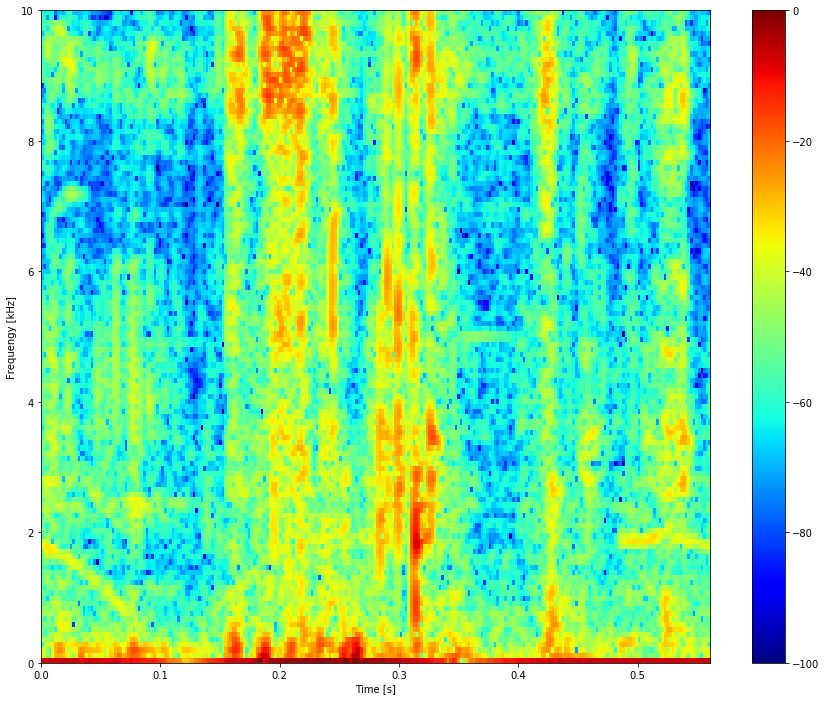

In [8]:
f, ax = plt.subplots(figsize=(15,12))

im = ax.imshow(S1, origin='lower', cmap=plt.cm.jet,extent=(0, L, 0, rate/2/1000 ),vmin=-100,vmax=0)
ax.axis('tight')
ax.set_ylabel('Frequengy [kHz]')
ax.set_xlabel('Time [s]')
f.colorbar(im, ax=ax)

In [2]:
for i in range(1,10):
    for j in range(1,10):
        print(i)
        print(j)
        i/=j #i=i/j
print(i)
        

1
1
1.0
2
0.5
3
0.16666666666666666
4
0.041666666666666664
5
0.008333333333333333
6
0.001388888888888889
7
0.0001984126984126984
8
2.48015873015873e-05
9
2
1
2.0
2
1.0
3
0.3333333333333333
4
0.08333333333333333
5
0.016666666666666666
6
0.002777777777777778
7
0.0003968253968253968
8
4.96031746031746e-05
9
3
1
3.0
2
1.5
3
0.5
4
0.125
5
0.025
6
0.004166666666666667
7
0.0005952380952380952
8
7.44047619047619e-05
9
4
1
4.0
2
2.0
3
0.6666666666666666
4
0.16666666666666666
5
0.03333333333333333
6
0.005555555555555556
7
0.0007936507936507937
8
9.92063492063492e-05
9
5
1
5.0
2
2.5
3
0.8333333333333334
4
0.20833333333333334
5
0.04166666666666667
6
0.006944444444444445
7
0.0009920634920634922
8
0.00012400793650793653
9
6
1
6.0
2
3.0
3
1.0
4
0.25
5
0.05
6
0.008333333333333333
7
0.0011904761904761904
8
0.0001488095238095238
9
7
1
7.0
2
3.5
3
1.1666666666666667
4
0.2916666666666667
5
0.058333333333333334
6
0.009722222222222222
7
0.001388888888888889
8
0.00017361111111111112
9
8
1
8.0
2
4.0
3
1.33333

In [3]:
a=9
b=5
a/=b
print(a)

1.8


gamma =  90.97908265483275 u0 =  0.23703587688841263


Text(0,0.5,'Velocity [m/s]')

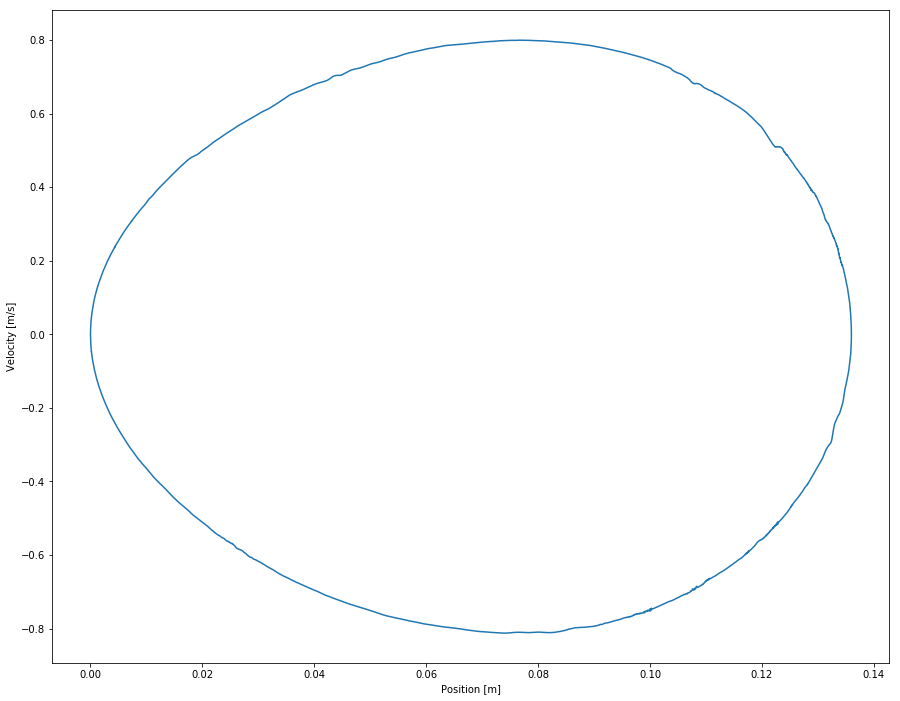

In [32]:
    icycle = 4
#for icycle in range(ncycle-1):
    cycle_start = cycle_edge[icycle]
    cycle_end = cycle_edge[icycle+1]
    p = acce[edge[cycle_start]:edge[cycle_end]]
    t = time[edge[cycle_start]:edge[cycle_end]]
    nt = len(t)
#if icycle == 0:
    pmean = 0.0
    for i in range(nt):
        pmean += p[i] #pmean=pmean+p[i]
    pmean /= float(nt) #pmean=pmean/nt
    for i in range(nt):
        p[i] -= pmean
        #p[i] *= -1
    ub1 = 0.0
    ub2 = 0.0
    xc = []
    xc.append(0)
    for i in range(1,nt):
        ub1 = ub2
        ub2 += (p[i]+p[i-1])/2*(t[i]-t[i-1])
        xc.append(xc[i-1]+(ub1 + ub2)/2*(t[i]-t[i-1]))
    T = t[nt-1] - t[0]
    q = -xc[nt -1] / T
    xp = []
    xp.append(0)
    for i in range(1,nt):
        xp.append(q*(t[i]-t[0])+xc[i])
    xpmin = min(xp)
    xpmax = max(xp)
    gamma = 2*R/(xpmax - xpmin)
    u0 = q * gamma
    print('gamma = ',gamma,'u0 = ',u0)
#else:
#    gamma =  91.24319715891828
#    u0 =  -0.10755856714674049
    
    x = []
    u = []
    x.append(0)
    u.append(u0)
    for i in range(1,nt):
        u.append(u[i-1] + gamma * (p[i] + p[i-1]) / 2 * (t[i] - t[i-1]))
        x.append(x[i-1] + (u[i] + u[i-1]) / 2 *(t[i] - t[i-1]))
    xmin = min(x)
    xmax = max(x)
    nt1 = nt/2
    for i in range(nt):
        if x[i] == xmax:
            nt1 = i
        x[i] -= xmin
        
    fig, ax = plt.subplots(figsize=(15,12))
    ax.plot(x,u)
    ax.set_xlabel('Position [m]')
    ax.set_ylabel('Velocity [m/s]')

Text(0,0.5,'Specific Kinetic Energy [J/kg]')

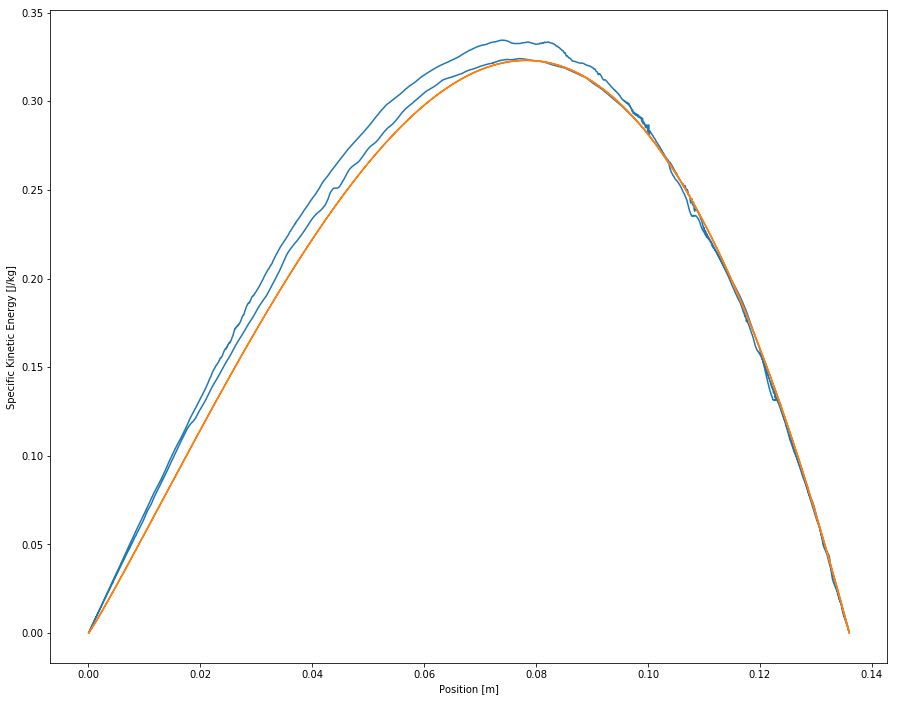

In [33]:
ratio = 0.54
nt2 = int(ratio*nt1)
    
L = 270.0 / 1000
eta = R / L
eta2 = eta * eta
omega = 2 * np.pi / T
ke2 = []
ua = 0.0
exponent = 1.065
R2 = 2*R
for i in range(nt):
    xi = (x[i]/R2)**exponent*R2
    xol = (L - R + xi) / L
    ct = -(eta * eta + xol * xol -1) / (2 * eta *xol)
    st2 = 1.0 - ct * ct
    if np.absolute(ct) > 1:
        #print('ct = ',ct,'st2 = ',st2)
        ct = 1.0
        st2 = 0.0
    st = np.sqrt(st2)
    u1 = R * omega * (st - eta * st * ct / np.sqrt(1.0 - eta2*st2))
    if i == nt2:
        ua = u1
    ke2.append(u1 * u1 / 2)

#uf = ua/u[nt2]
uf = 1
ke1 = []
for i in range(nt):
    u[i] *= uf
    ke1.append(u[i]*u[i]/2)


fig, ax = plt.subplots(figsize=(15,12))
color1 = 'tab:red'
color2 = 'tab:blue'
ax.plot(x,ke1,x,ke2)
ax.set_xlabel('Position [m]')
ax.set_ylabel('Specific Kinetic Energy [J/kg]')

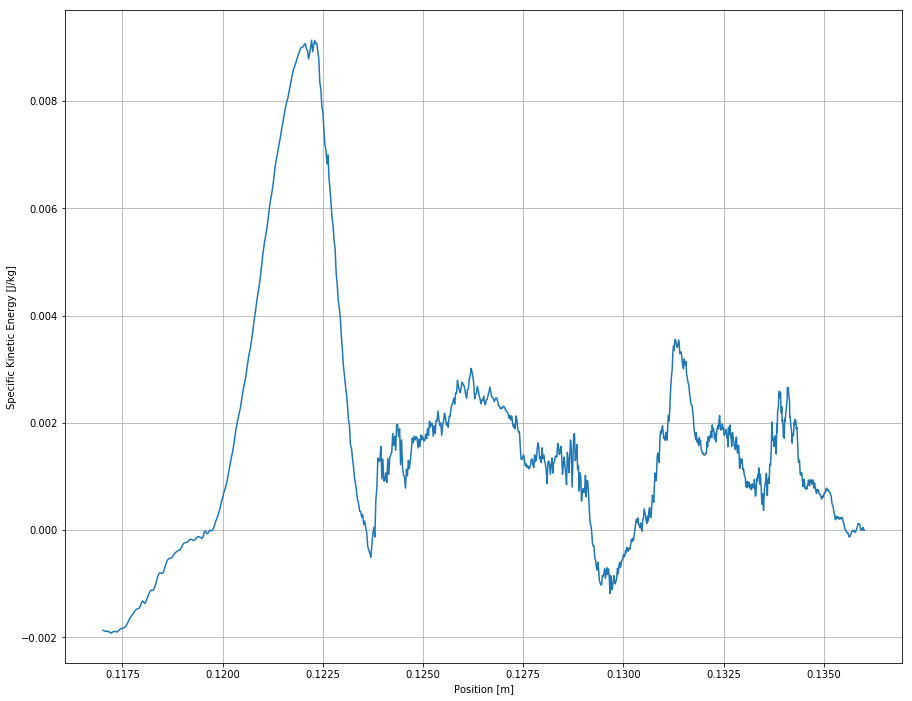

In [34]:
dke = []
x2 = []
xstart=0.117
for i in range(nt1):
    if x[i] > xstart:
        dke.append(ke2[i]-ke1[i])
        x2.append(x[i])
fig, ax = plt.subplots(figsize=(15,12))
ax.plot(x2,dke)
ax.set_xlabel('Position [m]')
ax.set_ylabel('Specific Kinetic Energy [J/kg]')
plt.grid(True)
#plt.ylim(-0.004,0.006)